# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf,isnan, when, count, col
from pyspark.sql.types import IntegerType
import pyspark.sql.functions as func
from pyspark.sql.functions import datediff,to_timestamp,to_date


from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import seaborn as sns
import datetime
import re



In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Creating Features") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json('mini_sparkify_event_data.json')
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [5]:
# check the count of df
df.count()

286500

In [6]:
# check the number of users
df.select("userId").dropDuplicates().count()

226

In [7]:
# check number of NAs in each column
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()


+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [8]:
# drop those records have null in user related features(firstName,gender,lastName,registration,userAgent)
df = df.filter(df.userId!="")

In [9]:
# change the original timestamp in the dataset to the common format
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df = df.withColumn("time", get_time(df.ts)).withColumn('registration_time',get_time(df.registration))


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [10]:
# Define churn : for userids who review 'Cancellation Confirmation' page, we assume they are churned
df=df.withColumn('whether_churn',when(col('page')=='Cancellation Confirmation', 1).otherwise(0))
user=df.groupBy('userId').agg({'whether_churn': 'sum'})
user.groupBy('sum(whether_churn)').count().show()

+------------------+-----+
|sum(whether_churn)|count|
+------------------+-----+
|                 0|  173|
|                 1|   52|
+------------------+-----+



So we know among these 225 userIds, 52 users churn and 173 users stay, the churn rate is about 23%.

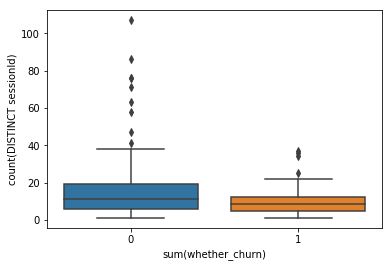

In [11]:
# EDA : first I am curious between these two groups of users, is there a difference between how many sessions they visited?
user_session=df.groupBy('userId').agg(func.sum('whether_churn'),func.countDistinct('sessionId'))

user_session = user_session.toPandas()

sns.boxplot(x='sum(whether_churn)', y='count(DISTINCT sessionId)',
            data=user_session)

we can observe that, those users who stay visit more sessions than those who churn.

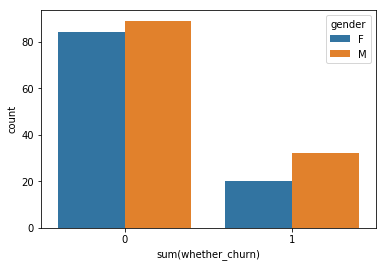

In [12]:
# EDA : second I want to know between these two groups of users, whether the gender distribution be similar
user3=df.groupBy('userId','gender').agg({'whether_churn': 'sum'}).toPandas()

# plot a barchart using seaborn
user3['count']=1
sns.barplot(x="sum(whether_churn)", y='count',hue="gender", data=user3,estimator=sum)


It looks like the female proportion  in stay group is higher than churn group.

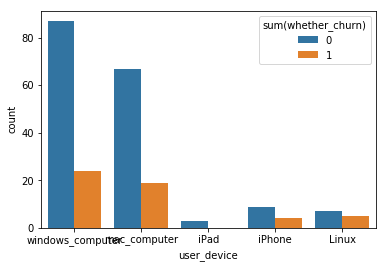

In [13]:
# EDA : third I want to see the device distribuiton of two groups of users.
user_device = when(
    col('userAgent').like('%Windows NT%') , 'windows_computer').when(col('userAgent') .like('%Macintosh%'), 'mac_computer'
).when(col('userAgent') .like('%X11%'), 'Linux').when(col('userAgent') .like('%iPhone%'), 'iPhone').otherwise('iPad')

df=df.withColumn('user_device',user_device)

user4=df.groupBy('userId','user_device').agg({'whether_churn': 'sum'}).toPandas()

# plot a barchart using seaborn
user4['count']=1
sns.barplot(x="user_device", y='count',hue="sum(whether_churn)", data=user4,estimator=sum)


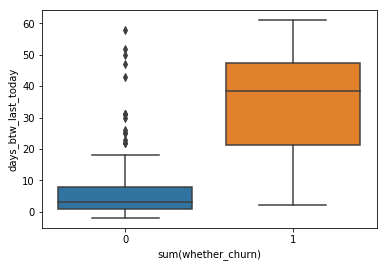

In [14]:
# EDA : Last I want to see the between these two groups of users, whether the distribution of days between last day(in whole dataset)
# and the last day the user visited similar

user_time=df.groupBy('userId').agg(func.sum('whether_churn'),func.max('time'))
user_time=user_time.select('userId','sum(whether_churn)',
                          to_timestamp('max(time)', 'yyyy-MM-dd HH:mm:ss').alias('last_time'))

user_time=user_time.withColumn('days_btw_last_today',datediff(to_date(lit("2018-12-03")),'last_time')).toPandas()

sns.boxplot(x='sum(whether_churn)', y='days_btw_last_today',
            data=user_time)


The distribution of days between last day(in whold dataset)and the last day the user visited similar looks very different between these two groups of users. It might a very useful feature.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [15]:
# create label for each user
user=df.groupBy('userId').agg({'whether_churn': 'sum'})

In [16]:
# session related feature : number of visited session, avg time of each session, avg gap time of sessions of each user

# calculate number of visited session of each user
user_session=df.groupBy('userId').agg(func.countDistinct('sessionId'))



# calculate avg time of each session and avg gap time of sessions of each user
user_session_time=df.groupBy('userId','sessionId').agg(func.min('time'),func.max('time')).orderBy('userId','sessionId')
user_session_time=user_session_time.select('userId','sessionId',
                          to_timestamp('min(time)', 'yyyy-MM-dd HH:mm:ss').alias('first_time'),
                          to_timestamp('max(time)', 'yyyy-MM-dd HH:mm:ss').alias('last_time'))

# calculate visited time of each session
user_session_time=user_session_time.withColumn('session_duration_mins',(col("last_time").cast("long") - col("first_time").cast("long"))/60)

# calculate gap time of each pair of close sessions 
from pyspark.sql.window import Window
user_session_time=user_session_time.withColumn('next_session_start_time',func.lead(user_session_time['first_time'])
                                 .over(Window.partitionBy("userId").orderBy('sessionId')))    

user_session_time=user_session_time.withColumn('gap_time',datediff('next_session_start_time','first_time'))

# aggregate these two features at user level
user_session_time=user_session_time.groupBy('userId').agg(func.mean('session_duration_mins').alias('avg_session_duration_mins'),
                                           func.mean('gap_time').alias('avg_gap_time_days')).na.fill(0)


#merge with user dataframe

user=user.join(user_session, ['userId'])
user=user.join(user_session_time, ['userId'])
user.show()

+------+------------------+-------------------------+-------------------------+------------------+
|userId|sum(whether_churn)|count(DISTINCT sessionId)|avg_session_duration_mins| avg_gap_time_days|
+------+------------------+-------------------------+-------------------------+------------------+
|100010|                 0|                        7|       154.48333333333332| 7.333333333333333|
|200002|                 0|                        6|                    266.4|               9.0|
|   125|                 1|                        1|       29.566666666666666|               0.0|
|    51|                 1|                       10|        872.3566666666668|1.6666666666666667|
|   124|                 0|                       29|        578.9942528735631| 2.142857142857143|
|     7|                 0|                        7|        87.64047619047619|               8.5|
|    54|                 1|                       37|       322.28963963963963|1.1666666666666667|
|    15|  

In [17]:
# check when is the most recent date in whole dataset
df.select('time').describe().show()

+-------+-------------------+
|summary|               time|
+-------+-------------------+
|  count|             278154|
|   mean|               null|
| stddev|               null|
|    min|2018-10-01 00:01:57|
|    max|2018-12-03 01:11:16|
+-------+-------------------+



In [18]:
#time_related feature: days between first visit and last visit, days between most resent date and first visit date,
# days between most resent date and last visit date

user_time=df.groupBy('userId','registration_time').agg(func.min('time'),func.max('time'))
user_time=user_time.select('userId',to_timestamp('registration_time', 'yyyy-MM-dd HH:mm:ss').alias('registration_time'),
                          to_timestamp('min(time)', 'yyyy-MM-dd HH:mm:ss').alias('first_time'),
                          to_timestamp('max(time)', 'yyyy-MM-dd HH:mm:ss').alias('last_time'))

user_time=user_time.withColumn('days_btw_first_last',datediff('last_time','first_time')).withColumn(
    'days_btw_last_today',datediff(to_date(lit("2018-12-03")),'last_time')).withColumn(
        'days_btw_first_today',datediff(to_date(lit("2018-12-03")),'first_time'))
           

user_time=user_time.select('userId','days_btw_first_last','days_btw_last_today','days_btw_first_today')

user=user.join(user_time, ['userId'])
user.show()

+------+------------------+-------------------------+-------------------------+------------------+-------------------+-------------------+--------------------+
|userId|sum(whether_churn)|count(DISTINCT sessionId)|avg_session_duration_mins| avg_gap_time_days|days_btw_first_last|days_btw_last_today|days_btw_first_today|
+------+------------------+-------------------------+-------------------------+------------------+-------------------+-------------------+--------------------+
|100010|                 0|                        7|       154.48333333333332| 7.333333333333333|                 44|                 12|                  56|
|200002|                 0|                        6|                    266.4|               9.0|                 45|                 18|                  63|
|   125|                 1|                        1|       29.566666666666666|               0.0|                  0|                 52|                  52|
|    51|                 1|             

In [19]:
# page view related feature: calculate number of visited pages, proportion of different types of pages
user_page_view=df.groupBy('userId').pivot('page').count()
user_page_view=user_page_view.na.fill(0).drop('Cancellation Confirmation','Cancel')

user_page_totalview=df.filter("page != 'Cancellation Confirmation' and page != 'Cancel'" ).groupBy('userId').count()

# change actual number to percentage 
user_page_view=user_page_view.join(user_page_totalview,['userId'])

columns=user_page_view.columns
columns=[column for column in columns if column not in ('userId', 'count')]

for colName in columns:
    user_page_view = user_page_view.withColumn(colName, col(colName)/col('count'))


# merge feature with user dataframe
user=user.join(user_page_view, ['userId'])
user.show()

+------+------------------+-------------------------+-------------------------+------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
|userId|sum(whether_churn)|count(DISTINCT sessionId)|avg_session_duration_mins| avg_gap_time_days|days_btw_first_last|days_btw_last_today|days_btw_first_today|               About|          Add Friend|     Add to Playlist|           Downgrade|               Error|                Help|                Home|              Logout|          NextSong|         Roll Advert|       Save Settings|            Settings|    Submit Downgrade|      Submit Upgrade|         Thumbs Down|       

In [20]:
# music related features
music=df.where(df['page'] == 'NextSong').select('artist','song',"userId")
music=music.withColumn('song2',concat(col('artist'),lit('-'),col('song')))

user_music_choice=music.groupby('userId').agg(func.count('song2').alias('count_song'),
                                              func.countDistinct('song2').alias('count_distinct_song'),
                                              func.countDistinct('artist').alias('count_distinct_artist'))


# merge feature with user dataframe
user=user.join(user_music_choice, ['userId'])
user.show()


+------+------------------+-------------------------+-------------------------+------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+----------+-------------------+---------------------+
|userId|sum(whether_churn)|count(DISTINCT sessionId)|avg_session_duration_mins| avg_gap_time_days|days_btw_first_last|days_btw_last_today|days_btw_first_today|               About|          Add Friend|     Add to Playlist|           Downgrade|               Error|                Help|                Home|              Logout|          NextSong|         Roll Advert|       Save Settings|            Settings|    Submit Downgr

In [21]:
# free/paid proportion of visited
user_level=df.groupBy('userId').pivot('level').count().fillna(0)
user_level=user_level.withColumn('free_portion',col('free')/(col('free')+col('paid'))).withColumn('paid_portion',col('paid')/(col('free')+col('paid')))
user_level=user_level.select('userId','free_portion','paid_portion')

user=user.join(user_level, ['userId'])
user.show()

+------+------------------+-------------------------+-------------------------+------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+----------+-------------------+---------------------+--------------------+-------------------+
|userId|sum(whether_churn)|count(DISTINCT sessionId)|avg_session_duration_mins| avg_gap_time_days|days_btw_first_last|days_btw_last_today|days_btw_first_today|               About|          Add Friend|     Add to Playlist|           Downgrade|               Error|                Help|                Home|              Logout|          NextSong|         Roll Advert|       Save Settin

In [22]:
# gender feature
user_gender=df.select("userId",'gender').dropDuplicates().groupBy('userId').pivot('gender').count()
user_gender=user_gender.na.fill(0)

user=user.join(user_gender, ['userId'])
user.show()

+------+------------------+-------------------------+-------------------------+------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+----------+-------------------+---------------------+--------------------+-------------------+---+---+
|userId|sum(whether_churn)|count(DISTINCT sessionId)|avg_session_duration_mins| avg_gap_time_days|days_btw_first_last|days_btw_last_today|days_btw_first_today|               About|          Add Friend|     Add to Playlist|           Downgrade|               Error|                Help|                Home|              Logout|          NextSong|         Roll Advert|       Sav

In [23]:
# device feature
user_gender=df.select("userId",'user_device').dropDuplicates().groupBy('userId').pivot('user_device').count()
user_gender=user_gender.na.fill(0)

user=user.join(user_gender, ['userId'])
user.show()

+------+------------------+-------------------------+-------------------------+------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+----------+-------------------+---------------------+--------------------+-------------------+---+---+-----+----+------+------------+----------------+
|userId|sum(whether_churn)|count(DISTINCT sessionId)|avg_session_duration_mins| avg_gap_time_days|days_btw_first_last|days_btw_last_today|days_btw_first_today|               About|          Add Friend|     Add to Playlist|           Downgrade|               Error|                Help|                Home|              Logout|  

In [24]:
user.write.save('final_data.csv', format="csv", header=True)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Model I - Logistic Regression

In [25]:
assembler = VectorAssembler(inputCols=user.columns[2:], outputCol="NumFeatures")
data = assembler.transform(user)

In [26]:
scaler = StandardScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

In [27]:
data = data.select(data['sum(whether_churn)'].alias("label"), data.ScaledNumFeatures.alias("features"))


### Train Test Split
As a first step break  data set into 80% of training data and set aside 20%. Set random seed to `16`.


In [28]:
train, test = data.randomSplit([0.8, 0.2], seed=16)
train = train.cache()

In [29]:
# first, let's try a single model logistic regression and use the default setting.
lr =  LogisticRegression()
cvModel_lr = lr.fit(train)

In [30]:
# plot the confumation matrix on test dataset
results= cvModel_lr.transform(test)
results.groupBy('label').pivot('prediction').count().show()

+-----+---+---+
|label|0.0|1.0|
+-----+---+---+
|    0| 32|  3|
|    1|  1|  8|
+-----+---+---+



From the confusion matrix,we can observe that the mdoel performs pretty well on test dataset. For Churn customer group, the recall rate is 88.9%, the precision rate is 72%.

### Model II - Decision Tree

In [4]:
df_final = spark.read.csv('final_data.csv', inferSchema =True,header=True)

In [5]:
assembler = VectorAssembler(inputCols=df_final.columns[2:], outputCol="NumFeatures")
data = assembler.transform(df_final)
data = data.select(data['sum(whether_churn)'].alias("label"), data.NumFeatures.alias("features"))


In [9]:
# secondly try decision tree.
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(data)
# Automatically identify categorical features, and index them.
# We specify maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=2).fit(data)


In [29]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.8, 0.2],seed=16)

# Train a DecisionTree model.
dt = DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dt])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)


In [31]:
# plot the confumation matrix on test dataset
predictions.groupBy('label').pivot('prediction').count().show()

+-----+---+---+
|label|0.0|1.0|
+-----+---+---+
|    1|  2|  8|
|    0| 28|  1|
+-----+---+---+



From the confusion matrix,we can observe that for Churn customer group, the recall rate is 80%, the precision rate is 89%.

### MODEL III RANDOM FOREST

In [32]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)



In [33]:
predictions.groupBy('label').pivot('prediction').count().show()

+-----+---+----+
|label|0.0| 1.0|
+-----+---+----+
|    1|  4|   6|
|    0| 29|null|
+-----+---+----+



In [10]:
# tune in parameter
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import BinaryClassificationEvaluator

(trainingData, testData) = data.randomSplit([0.8, 0.2],seed=16)

rf2 = RandomForestClassifier(labelCol="label", featuresCol="features")
paramGrid = ParamGridBuilder() \
    .addGrid(rf2.numTrees,[20,30,50]) \
    .addGrid(rf2.maxDepth,[5,10,20]) \
    .build()
crossval_rf = CrossValidator(estimator=rf2,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator())
cvModel_rf = crossval_rf.fit(trainingData)
cvModel_rf.avgMetrics

[0.9239684118890683,
 0.9226091109452941,
 0.9226091109452941,
 0.9242875056999544,
 0.9243850382530273,
 0.9243850382530273,
 0.9166476207584279,
 0.9223919484401699,
 0.9223919484401699]

In [11]:
# used the tuned models to replot the confusion matrix
results = cvModel_rf.transform(testData)
results.groupBy('label').pivot('prediction').count().show()

+-----+---+----+
|label|0.0| 1.0|
+-----+---+----+
|    1|  4|   6|
|    0| 29|null|
+-----+---+----+



From the confusion matrix,we can observe that for Churn customer group, the recall rate is 60%, the precision rate is 100%.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.